In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1. <font color = blue> Install and Import the Required Libraries

In [ ]:
# Install all the required libraries

!pip install protobuf==4.24.4

In [ ]:
!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q


In [4]:
# Import all the required Libraries
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import openai
import chromadb
from google.colab import userdata

In [5]:
# Set the API key
filepath = "/content/drive/MyDrive/GenAI/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

**First Step:**

**Embedding layer** - is not straight forward. First from text corpus to processing documents -- has a lot of pre-processing.

we process the documents (in this case, the documents pertain to the insurance domain) to extract the text, split it into smaller chunks and then pass them to the embedding model.

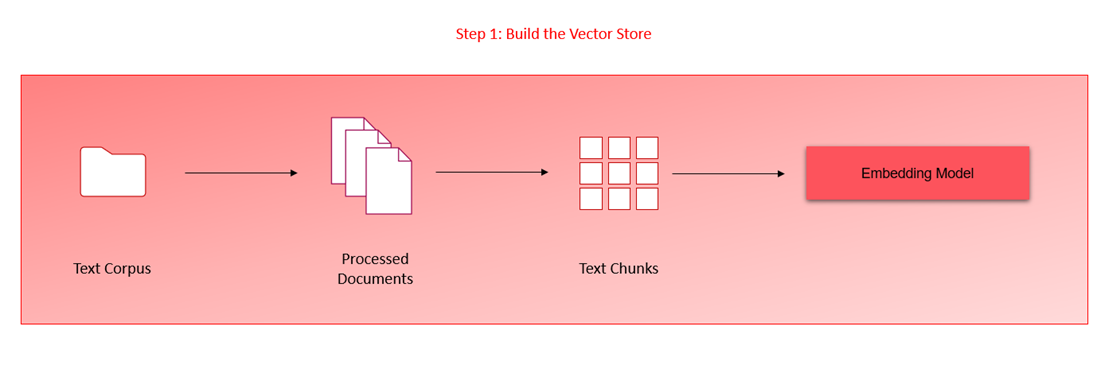

## 2. <font color = blue> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

#### <font color = blue> 2.1 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [6]:
# Define the path where all pdf documents are present
pdf_path = "/content/drive/MyDrive/GenAI/HelpMateAI/"

In [7]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [8]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

#### Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [9]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [10]:
# Concatenate all the PDFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [11]:
insurance_pdfs_data.shape

(64, 3)

In [12]:
# Checking sample 2 records
insurance_pdfs_data.sample(2)

Page No.                                          Page_Text  \
2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
10  Page 11  (2) has been placed with the Member or spouse ...   

                                 Document Name  
2   Principal-Sample-Life-Insurance-Policy.pdf  
10  Principal-Sample-Life-Insurance-Policy.pdf

In [13]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [14]:
insurance_pdfs_data.sample(2)

Page No.                                          Page_Text  \
1    Page 2                 This page left blank intentionally   
21  Page 22  The number of Members insured for Dependent Li...   

                                 Document Name  Text_Length  
1   Principal-Sample-Life-Insurance-Policy.pdf            5  
21  Principal-Sample-Life-Insurance-Policy.pdf          222

In [15]:
max(insurance_pdfs_data['Text_Length'])

462

To ignore the blank pages with minimum of 10 words, we use the following code to ignore the blank page -- which has minimun of 10 words or only has header or footer

In [16]:
# Retain only the rows with a text length of at least 10
insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data.head()

Page No.                                          Page_Text  \
0   Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
2   Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
4   Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
5   Page 6  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   
6   Page 7  Section A – Eligibility Member Life Insurance ...   

                                Document Name  Text_Length  
0  Principal-Sample-Life-Insurance-Policy.pdf           30  
2  Principal-Sample-Life-Insurance-Policy.pdf          230  
4  Principal-Sample-Life-Insurance-Policy.pdf          110  
5  Principal-Sample-Life-Insurance-Policy.pdf          153  
6  Principal-Sample-Life-Insurance-Policy.pdf          176

In [17]:
# Store the metadata for each page in a separate column
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

In [18]:
insurance_pdfs_data.head()

Page No.                                          Page_Text  \
0   Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...   
2   Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   
4   Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   
5   Page 6  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   
6   Page 7  Section A – Eligibility Member Life Insurance ...   

                                Document Name  Text_Length  \
0  Principal-Sample-Life-Insurance-Policy.pdf           30   
2  Principal-Sample-Life-Insurance-Policy.pdf          230   
4  Principal-Sample-Life-Insurance-Policy.pdf          110   
5  Principal-Sample-Life-Insurance-Policy.pdf          153   
6  Principal-Sample-Life-Insurance-Policy.pdf          176   

                                            Metadata  
0  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
2  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
4  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
5  {'Policy_Name': 'Principal-Sample-Life-Insuran...  
6  {'Policy_Name': 'Principal-Sample-Life-Insuran...

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = blue> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [19]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [20]:
# Define the path where chroma collections will be stored
chroma_data_path = '/content/drive/MyDrive/GenAI/HelpMateAI/ChromaDB_Path'

In [21]:
# Call PersistentClient()

client = chromadb.PersistentClient(path=chroma_data_path)

In [22]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [23]:
from chromadb.utils import embedding_functions

sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [25]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=sentence_transformer_ef)

In [26]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [27]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.02592185,  0.04777745,  0.05585777, ..., -0.04932651,
         -0.05851148,  0.02355192],
        [-0.10579573, -0.00053028,  0.01657761, ..., -0.03772434,
          0.03662248, -0.04041133],
        [-0.06354077,  0.0587016 ,  0.07262776, ..., -0.07400379,
         -0.02375575, -0.0081062 ]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees o

In [28]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [29]:
cache_collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

**Semantic Search Layer**

As with any good system design, we need to consider a scenario when the application is scaled - suppose the number of documents increases or multiple users are using the application. Such a scenario opens up multiple concerns about the system’s performance

- How will the system handle multiple queries simultaneously?
- Is there scope to improve the system’s overall performance in search and retrieval?



The first concern can be solved by using vector databases and scaling up the compute units (clusters/server) for the application. For the second concern, an improvement to the overall system design is required which can be achieved by implementing a cache collection in the vector database that stores previous queries and their results in the vector database. Let’s hear more on this from Akshay in the video below.

**System Design of Semantic Search Layer:**







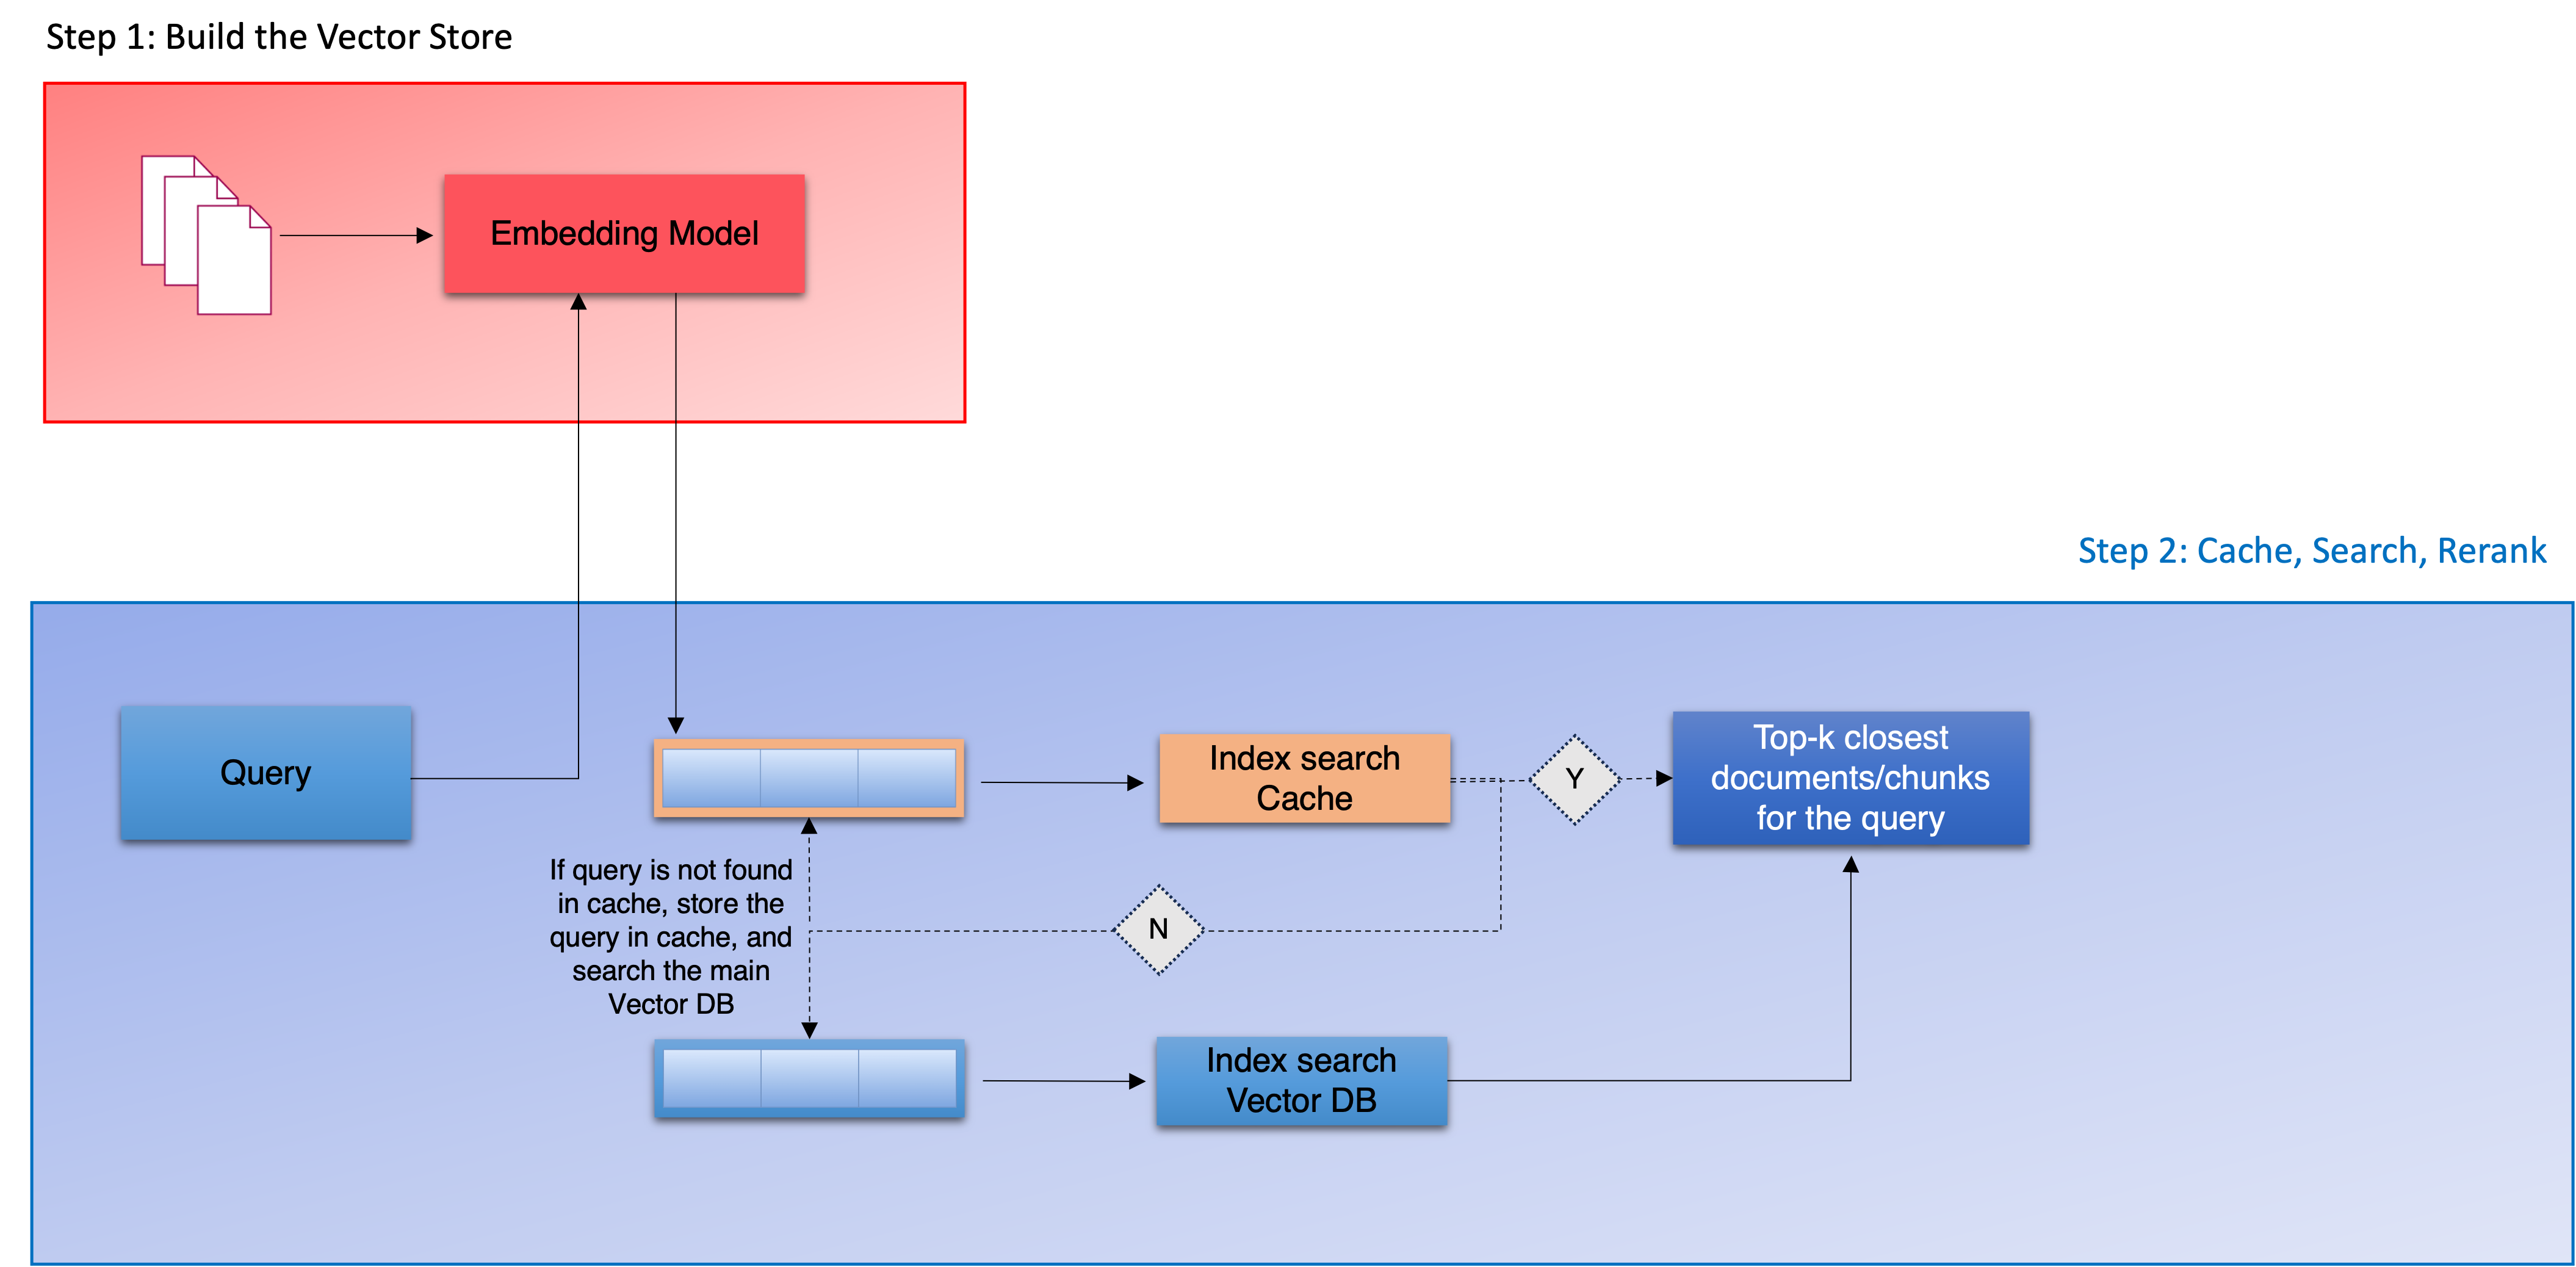

## 4. <font color = blue> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

 The design considerations for creating a cache layer in the semantic search system.

 Documnet query --
 - first search in cache
  - if find return top k closeset / chunks of k documents the results
  - if not find search in main vector db
    - store the new query in cache
      - if similar query occurs in future, it's easy to return answer
    - search and index on the main vector db and return top k closeset / chunks of k documents the results
    


**Query 1:**

In [30]:
# Read the user query

query = input()

Is this a good insurance plan?


In [31]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [32]:
cache_results

{'ids': [[]],
 'embeddings': None,
 'documents': [[]],
 'uris': None,
 'data': None,
 'metadatas': [[]],
 'distances': [[]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [33]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['27', '43', '2', '39', '17', '19', '50', '56', '5', '16']]), ('embeddings', None), ('documents', [["(6) If, on the date a Member becomes eligible for any increased or additional Scheduled Benefit amount, fewer than five Members are insured. (7) To make effective any Scheduled Benefit amounts for the Member that are, initially or through later increases, in excess of: - $10,000 for Members who are under age 65; and - $10,000 for Members who are age 65 or over but under age 70; and - *$10,000 for Members who are age 70 or over. *If a Member is insured under this Group Policy on its Date of Issue and this insurance replaces insurance in force on the day immediately before the Date of Issue: the lesser of the amount shown above or the amount for which the Member was insured under the replaced insurance. f. Effective Date for Benefit Changes Due to Change in Insurance Class (1) A change in the Member's Scheduled Benefit amount because of a change in the Member's insura

In [34]:
# Implementing Cache in Semantic Search

# Set a threshold for cache searchA
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the top 10 results
    results = insurance_collection.query(
    query_texts=query,
    n_results=10
    )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        if key != 'embeddings':
            for i in range(10):  # Top 10 results
                if isinstance(val, list) and len(val) > 0 and len(val[0]) > i:
                    Keys.append(f"{key}{i}")
                    Values.append(str(val[0][i]))
                else:
                    print(f"Skipping key: {key} at index {i}, as it doesn't have enough values.")



    cache_collection.add(
        documents= [query],
        ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
        metadatas = dict(zip(Keys, Values))
    )

    print("Not found in cache. Found in main collection.")

    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)
    results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    print("Found in cache!")

    # Create a DataFrame
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Skipping key: included at index 9, as it doesn't have enough values.
Not found in cache. Found in main collection.


In [35]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
3  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 22', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 53', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 59', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 8', 'Policy_Name': 'Princip...   
9  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  (6) If, on the date a Member becomes eligible ...   1.129527  27  
1  PART IV - BENEFITS Section A - Member Life Ins...   1.206507  43  
2  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   1.208151   2  
3  Section F - Individual Purchase Rights Article...   1.220087  39  
4  Section B - Premiums Article 1 - Payment Respo...   1.235074  17  
5  The number of Members insured for Dependent Li...   1.240450  19  
6  Section B - Member Accidental Death and Dismem...   1.243884  50  
7  Section C - Dependent Life Insurance Article 1...   1.252144  56  
8  Section A - Member Life Insurance Schedule of ...   1.252528   5  
9  T he Principal has complete discretion to cons...   1.260384  16

**Query 2:**

In [37]:
# Read the user another different query

query2 = input()

What does it mean by 'the later of the Date of Issue'?


In [38]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results2 = cache_collection.query(
    query_texts=query2,
    n_results=1
)

In [39]:
cache_results2

{'ids': [['Is this a good insurance plan?']],
 'embeddings': None,
 'documents': [['Is this a good insurance plan?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '1.129527451196209',
    'distances1': '1.2065071921445503',
    'distances2': '1.2081512619548365',
    'distances3': '1.220087389617986',
    'distances4': '1.2350742475041703',
    'distances5': '1.2404498688615406',
    'distances6': '1.2438843543734626',
    'distances7': '1.2521436359442382',
    'distances8': '1.2525277489950308',
    'distances9': '1.2603842080414922',
    'documents0': "(6) If, on the date a Member becomes eligible for any increased or additional Scheduled Benefit amount, fewer than five Members are insured. (7) To make effective any Scheduled Benefit amounts for the Member that are, initially or through later increases, in excess of: - $10,000 for Members who are under age 65; and - $10,000 for Members who are age 65 or over but under age 70; and - *$10,000 for Members who are age 7

In [40]:
# Set a threshold for cache search
threshold = 0.2

ids2 = []
documents2 = []
distances2 = []
metadatas2 = []
results_df2 = pd.DataFrame()

# Check if cache contains valid results
if cache_results2['distances'][0] == [] or cache_results2['distances'][0][0] > threshold:
    # Query the main collection
    results = insurance_collection.query(
        query_texts=query2,
        n_results=10
    )

    # Prepare data for storing in cache
    Keys2 = []
    Values2 = []

    for key, val in results.items():
        if val is None or not val:
            print(f"Skipping key {key} due to None or empty value.")
            continue
        if key != 'embeddings':
            # Ensure val[0] is a list before accessing it
            if isinstance(val[0], list):
                for i in range(min(len(val[0]), 10)):  # Top 10 or fewer
                    Keys2.append(str(key) + str(i))
                    Values2.append(str(val[0][i]))
            else:
                print(f"Skipping key {key} as val[0] is not a list.")

    # Add query and results to the cache
    cache_collection.add(
        documents=[query2],
        ids=[query2],  # You can replace with unique integer IDs if needed
        metadatas=dict(zip(Keys2, Values2))
    )

    print("Not found in cache. Found in main collection.")

    # Create a DataFrame for the results
    result_dict2 = {
        'Metadatas': results['metadatas'][0],
        'Documents': results['documents'][0],
        'Distances': results['distances'][0],
        "IDs": results["ids"][0]
    }
    results_df2 = pd.DataFrame.from_dict(result_dict2)
    print(results_df2)

# If the query results are found in the cache
elif cache_results2['distances'][0][0] <= threshold:
    cache_result_dict2 = cache_results2['metadatas'][0][0]

    # Extract data from cache
    for key, value in cache_result_dict2.items():
        if 'ids' in key:
            ids2.append(value)
        elif 'documents' in key:
            documents2.append(value)
        elif 'distances' in key:
            distances2.append(value)
        elif 'metadatas' in key:
            metadatas2.append(value)

    print("Found in cache!")

    # Create a DataFrame for the cached results
    results_df2 = pd.DataFrame({
        'IDs': ids2,
        'Documents': documents2,
        'Distances': distances2,
        'Metadatas': metadatas2
    })
    print(results_df2)


Skipping key embeddings due to None or empty value.
Skipping key uris due to None or empty value.
Skipping key data due to None or empty value.
Skipping key included as val[0] is not a list.
Not found in cache. Found in main collection.
                                           Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 27', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 36', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 34', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 61', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 28', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 24', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  Insurance for which Proof of Good Health is re...   1.200995  26  
1  I f

In [41]:
results_df2

Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 27', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 36', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 34', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 61', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 28', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 24', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  Insurance for which Proof of Good Health is re...   1.200995  26  
1  I f a Member's Dependent is employed and is co...   1.259136  24  
2  b . on any date the definition of Member or De...   1.332726  18  
3  Scheduled Benefit in force for the Member befo...   1.349086  28  
4  A Member's insurance under this Group Policy f...   1.359286  33  
5  provided The Principal has been notified of th...   1.387343  31  
6  Section D - Claim Procedures Article 1 - Notic...   1.391411  58  
7  Section B - Effective Dates Article 1 - Member...   1.394463  25  
8  (6) If, on the date a Member becomes eligible ...   1.409443  27  
9  T he Principal may terminate the Policyholder'...   1.421555  21

**Query 3:**

In [42]:
# Read the user another different query

query3 = input()

What are the default benefits and provisions of the Group Policy?'


In [43]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results3 = cache_collection.query(
    query_texts=query3,
    n_results=1
)

In [44]:
cache_results3

{'ids': [['Is this a good insurance plan?']],
 'embeddings': None,
 'documents': [['Is this a good insurance plan?']],
 'uris': None,
 'data': None,
 'metadatas': [[{'distances0': '1.129527451196209',
    'distances1': '1.2065071921445503',
    'distances2': '1.2081512619548365',
    'distances3': '1.220087389617986',
    'distances4': '1.2350742475041703',
    'distances5': '1.2404498688615406',
    'distances6': '1.2438843543734626',
    'distances7': '1.2521436359442382',
    'distances8': '1.2525277489950308',
    'distances9': '1.2603842080414922',
    'documents0': "(6) If, on the date a Member becomes eligible for any increased or additional Scheduled Benefit amount, fewer than five Members are insured. (7) To make effective any Scheduled Benefit amounts for the Member that are, initially or through later increases, in excess of: - $10,000 for Members who are under age 65; and - $10,000 for Members who are age 65 or over but under age 70; and - *$10,000 for Members who are age 7

In [45]:
# Set a threshold for cache search
threshold = 0.2

ids3 = []
documents3 = []
distances3 = []
metadatas3 = []
results_df3 = pd.DataFrame()

# Check if the cache has results or if distances exceed the threshold
if not cache_results3['distances'][0] or cache_results3['distances'][0][0] > threshold:
    # Query the main collection
    results = insurance_collection.query(
        query_texts=query3,
        n_results=10
    )

    # Prepare keys and values for cache storage
    Keys3 = []
    Values3 = []

    for key, val in results.items():
        if val is None:
            continue
        if key != 'embeddings':
            for i in range(len(val[0])):  # Use the actual length of the list to avoid IndexError
                Keys3.append(f"{key}{i}")
                Values3.append(str(val[0][i]))

    # Add query and results to cache
    cache_collection.add(
        documents=[query3],
        ids=[query3],
        metadatas=dict(zip(Keys3, Values3))
    )

    print("Not found in cache. Found in main collection.")

    # Construct a results DataFrame
    result_dict3 = {
        'Metadatas': results['metadatas'][0],
        'Documents': results['documents'][0],
        'Distances': results['distances'][0],
        'IDs': results['ids'][0]
    }
    results_df3 = pd.DataFrame.from_dict(result_dict3)

else:
    # Cache hit: retrieve results
    cache_result_dict3 = cache_results3['metadatas'][0][0]

    for key, value in cache_result_dict3.items():
        if 'ids' in key:
            ids3.append(value)
        elif 'documents' in key:
            documents3.append(value)
        elif 'distances' in key:
            distances3.append(value)
        elif 'metadatas' in key:
            metadatas3.append(value)

    print("Found in cache!")

    # Construct a results DataFrame
    results_df3 = pd.DataFrame({
        'IDs': ids3,
        'Documents': documents3,
        'Distances': distances3,
        'Metadatas': metadatas3
    })

Not found in cache. Found in main collection.


In [46]:
results_df3

Metadatas  \
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 6', 'Policy_Name': 'Princip...   
4  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
6  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 33', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 13', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  PART II - POLICY ADMINISTRATION Section A - Co...   0.852389  13  
1  T he Principal has complete discretion to cons...   0.869788  16  
2  a. be actively engaged in business for profit ...   0.957547  14  
3  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   0.996698   3  
4  Section F - Individual Purchase Rights Article...   1.002786  39  
5  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   1.045446   1  
6  Scheduled Benefit in force for the Member befo...   1.071877  28  
7  b . on any date the definition of Member or De...   1.102897  18  
8  a . In no event will Dependent Life Insurance ...   1.108423  30  
9  a . A licensed Doctor of Medicine (M.D.) or Os...   1.108584  10

A semantic cache stores the meaning of a query or request instead of only the raw data along with the responses. This can reduce the number of queries the database needs to process by recalling previous queries and their results. The cache system can now circumvent the semantic search layer, which has been the bottleneck of the system, and directly provide responses for the queries that have already been generated before and stored in the cache collection. Now, when the query is passed to the application, its vector representation is generated and then searched in the cache collection first. If the query is not found in the cache collection, the system queries the main collection and finds the top k closest documents or chunks for the query. The results are then returned to the user and, simultaneously, are stored in the cache alongwith the query. Customising and monitoring the cache's performance can also make it more efficient. Since the cache stores previous queries and results, it can quickly provide the results of a query without processing it. As a result, response times can be faster, and users can experience better application performance.

## 5. <font color = blue> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

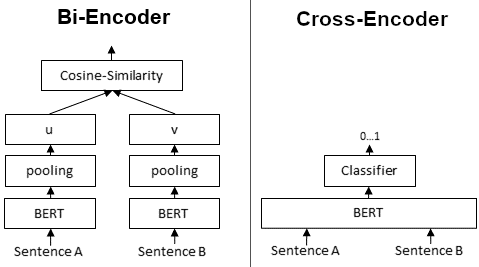

<br>

 The re-ranking stage is the next step in building the semantic search pipeline. So far, in our semantic search application, the system returns the top K documents that contain information relevant to the user’s query. The quality and accuracy of the information contained in these chunks or documents may vary - the system might retrieve documents that are not quite relevant to the search query. The purpose of the re-ranking layer is to sift through these top K results, verify the accuracy of the results in terms of the query and rank them or assign an importance score to these results for the query. Here are some of the benefits of using re-ranking in generative search:
- Improved accuracy and relevance of the generated results
- Reduced amount of irrelevant or inaccurate information presented to the user
- More personalised and informative search results
- Ability to tailor the search results to specific tasks or domains



Traditionally, many methods of re-rank methods have been used in search such as Reciprocal Rank Fusion (RRF), hybrid search methods and cross-encoder models. For this project, we will focus on the popular method of using cross-encoders for our re-ranking task. The image below illustrates the re-ranking component once the search results have been collected by the semantic search layer.

**Search - with Cross Encoders System Design**

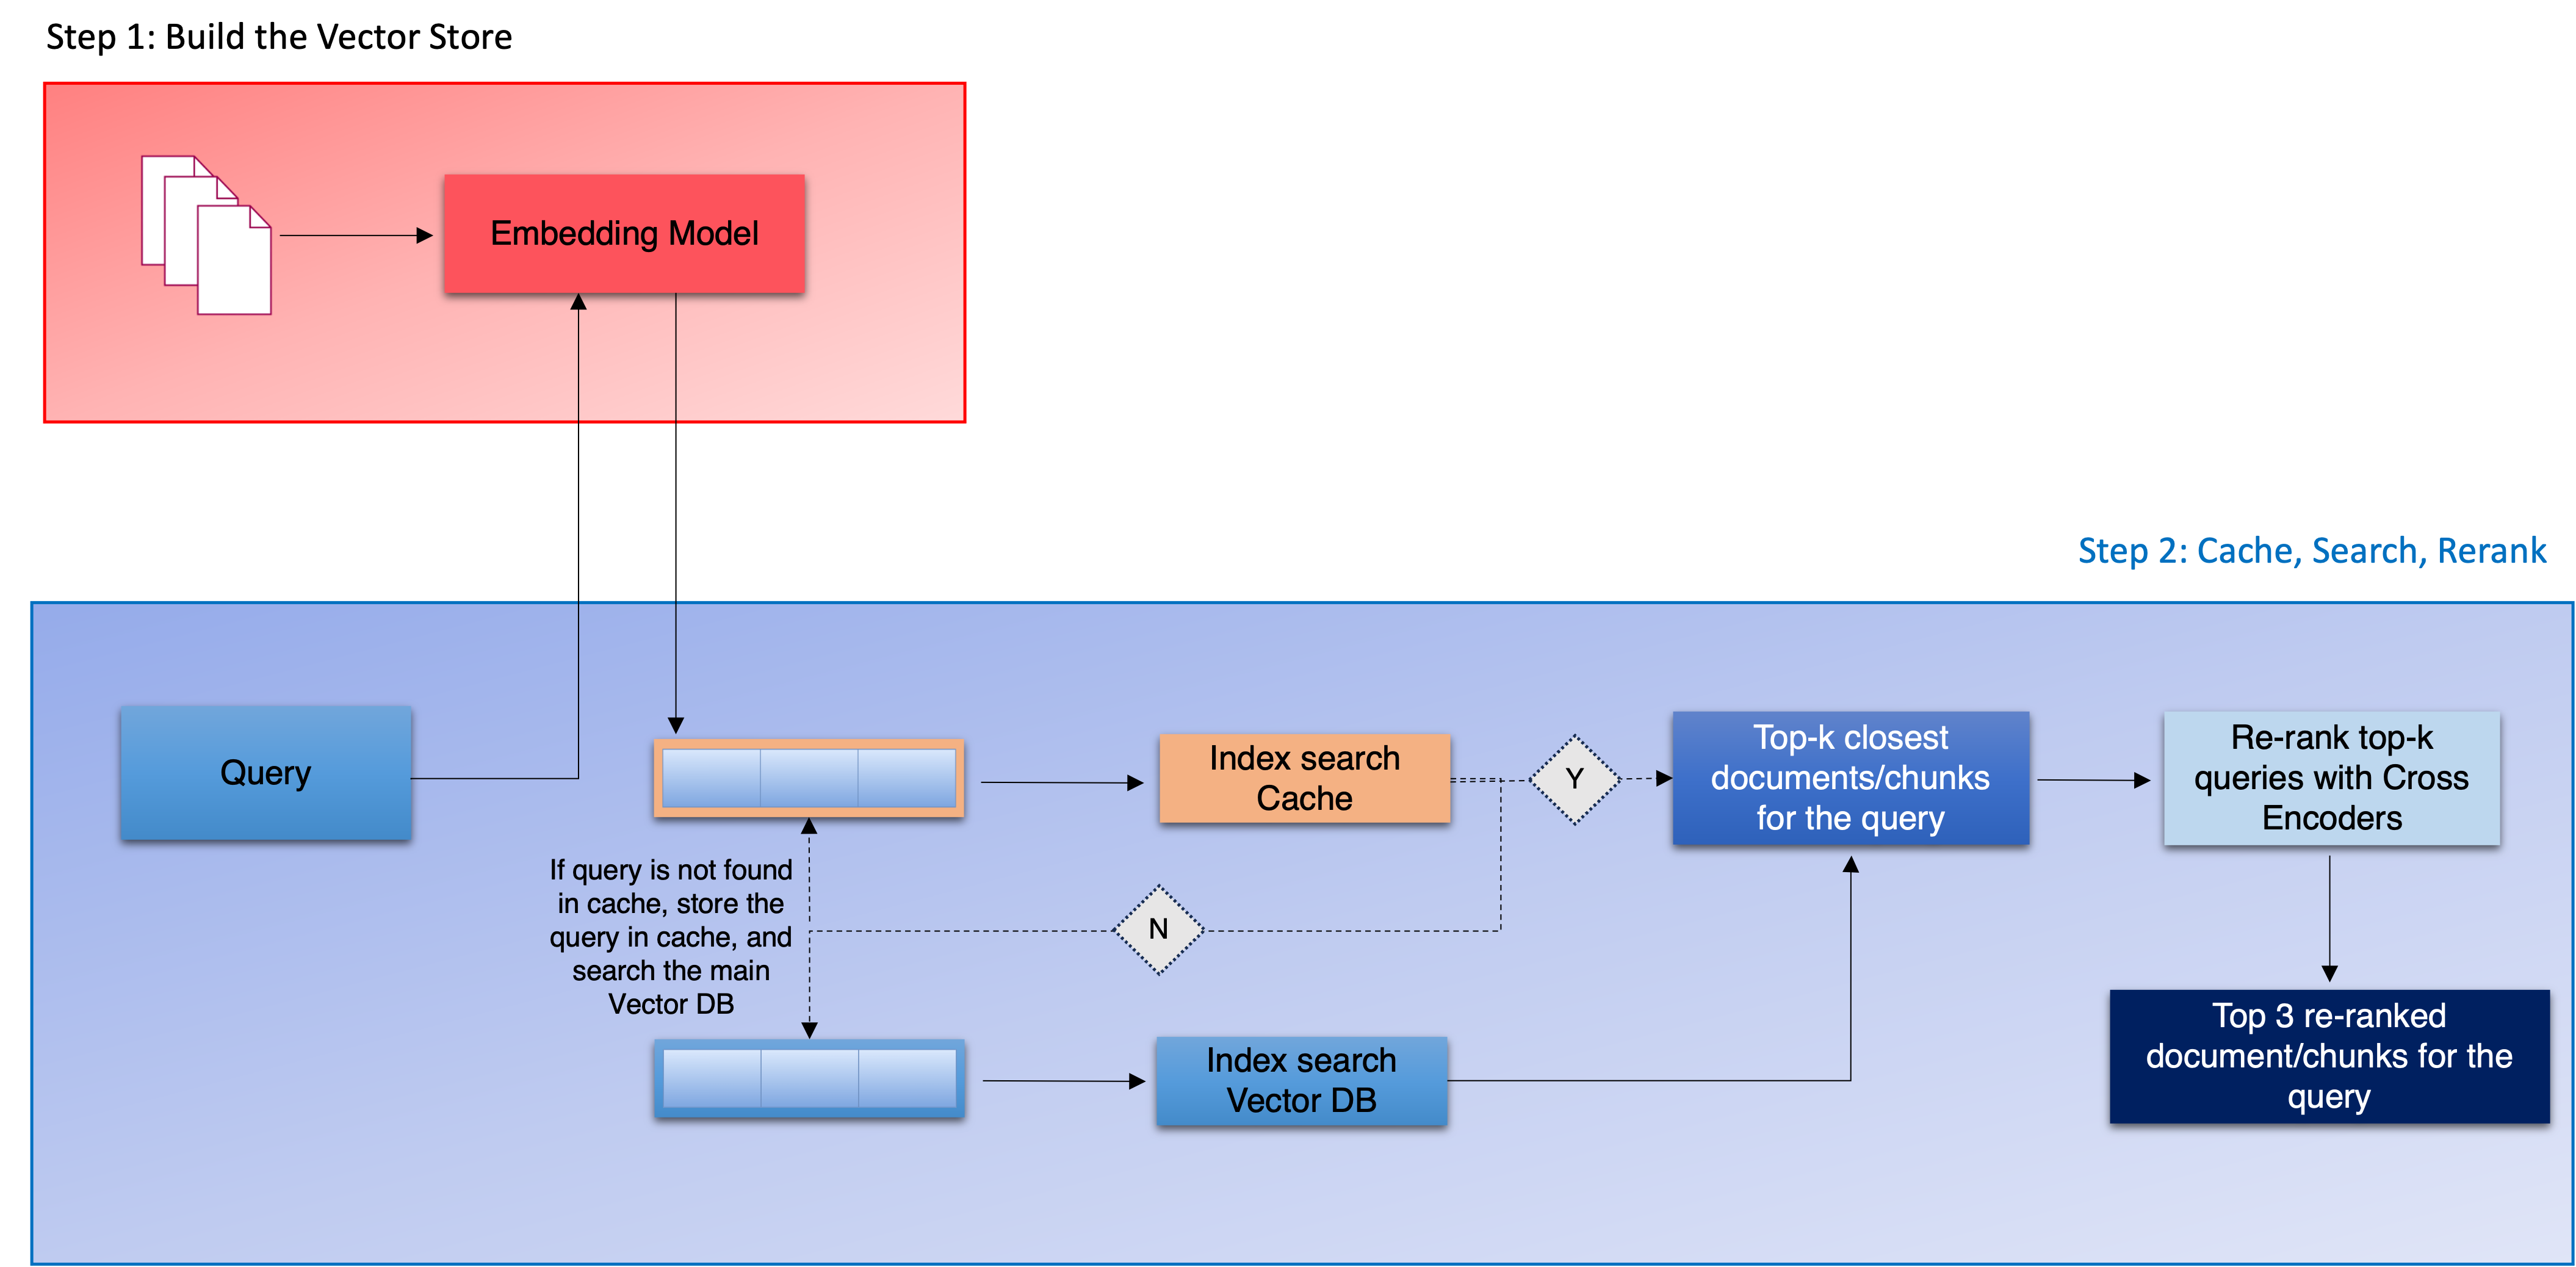

In [47]:
results_df.head()

Metadatas  \
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
3  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  (6) If, on the date a Member becomes eligible ...   1.129527  27  
1  PART IV - BENEFITS Section A - Member Life Ins...   1.206507  43  
2  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   1.208151   2  
3  Section F - Individual Purchase Rights Article...   1.220087  39  
4  Section B - Premiums Article 1 - Payment Respo...   1.235074  17

In [48]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [49]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [50]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [51]:
scores

array([  3.8467615, -11.25288  ], dtype=float32)

In cross-encoders,earlier from 0-1. But now the values now can range from +ve values to negative values. +ve indicates the similarity whereas -ve shows the dissimilarity.

Cross-encoders input must be a list tof lists

In [52]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [53]:
cross_rerank_scores

array([ -5.717171 ,  -6.539208 ,  -9.329857 ,  -4.8376846,  -9.456009 ,
       -10.282003 ,  -6.2758827,  -6.5185328, -10.712076 ,  -8.74995  ],
      dtype=float32)

In [54]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [55]:
results_df

Metadatas  \
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   
3  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 20', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 22', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 53', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 59', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 8', 'Policy_Name': 'Princip...   
9  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  (6) If, on the date a Member becomes eligible ...   1.129527  27   
1  PART IV - BENEFITS Section A - Member Life Ins...   1.206507  43   
2  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   1.208151   2   
3  Section F - Individual Purchase Rights Article...   1.220087  39   
4  Section B - Premiums Article 1 - Payment Respo...   1.235074  17   
5  The number of Members insured for Dependent Li...   1.240450  19   
6  Section B - Member Accidental Death and Dismem...   1.243884  50   
7  Section C - Dependent Life Insurance Article 1...   1.252144  56   
8  Section A - Member Life Insurance Schedule of ...   1.252528   5   
9  T he Principal has complete discretion to cons...   1.260384  16   

   Reranked_scores  
0        -5.717171  
1        -6.539208  
2        -9.329857  
3        -4.837685  
4        -9.456009  
5       -10.282003  
6        -6.275883  
7        -6.518533  
8       -10.712076  
9        -8.749950

In [56]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

Metadatas  \
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 46', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 5', 'Policy_Name': 'Princip...   

                                           Documents  Distances IDs  \
0  (6) If, on the date a Member becomes eligible ...   1.129527  27   
1  PART IV - BENEFITS Section A - Member Life Ins...   1.206507  43   
2  PRINCIPAL LIFE INSURANCE COMPANY (called The P...   1.208151   2   

   Reranked_scores  
0        -5.717171  
1        -6.539208  
2        -9.329857

In [57]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

Metadatas  \
3  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 53', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
3  Section F - Individual Purchase Rights Article...   1.220087  39   
0  (6) If, on the date a Member becomes eligible ...   1.129527  27   
6  Section B - Member Accidental Death and Dismem...   1.243884  50   

   Reranked_scores  
3        -4.837685  
0        -5.717171  
6        -6.275883

In [58]:
top_3_RAG_q1 = top_3_rerank[["Documents", "Metadatas"]][:3]

In [59]:
top_3_RAG_q1

Documents  \
3  Section F - Individual Purchase Rights Article...   
0  (6) If, on the date a Member becomes eligible ...   
6  Section B - Member Accidental Death and Dismem...   

                                           Metadatas  
3  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...  
0  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...  
6  {'Page_No.': 'Page 53', 'Policy_Name': 'Princi...

**For 2nd Query**

In [60]:
results_df2.head()

Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 27', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 36', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  Insurance for which Proof of Good Health is re...   1.200995  26  
1  I f a Member's Dependent is employed and is co...   1.259136  24  
2  b . on any date the definition of Member or De...   1.332726  18  
3  Scheduled Benefit in force for the Member befo...   1.349086  28  
4  A Member's insurance under this Group Policy f...   1.359286  33

In [61]:
query2

"What does it mean by 'the later of the Date of Issue'?"

In [62]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs2 = [[query2, response] for response in results_df2['Documents']]
cross_rerank_scores2 = cross_encoder.predict(cross_inputs2)

In [63]:
cross_rerank_scores2

array([ -3.987041 ,  -8.987306 ,  -6.4716063,  -6.414855 ,  -6.603662 ,
        -8.85088  ,  -8.264673 ,  -8.286314 ,  -4.0928974, -10.221119 ],
      dtype=float32)

In [64]:
# Store the rerank_scores in results_df

results_df2['Reranked_scores'] = cross_rerank_scores2

In [65]:
results_df2

Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 27', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
4  {'Page_No.': 'Page 36', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 34', 'Policy_Name': 'Princi...   
6  {'Page_No.': 'Page 61', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 28', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 24', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  Insurance for which Proof of Good Health is re...   1.200995  26   
1  I f a Member's Dependent is employed and is co...   1.259136  24   
2  b . on any date the definition of Member or De...   1.332726  18   
3  Scheduled Benefit in force for the Member befo...   1.349086  28   
4  A Member's insurance under this Group Policy f...   1.359286  33   
5  provided The Principal has been notified of th...   1.387343  31   
6  Section D - Claim Procedures Article 1 - Notic...   1.391411  58   
7  Section B - Effective Dates Article 1 - Member...   1.394463  25   
8  (6) If, on the date a Member becomes eligible ...   1.409443  27   
9  T he Principal may terminate the Policyholder'...   1.421555  21   

   Reranked_scores  
0        -3.987041  
1        -8.987306  
2        -6.471606  
3        -6.414855  
4        -6.603662  
5        -8.850880  
6        -8.264673  
7        -8.286314  
8        -4.092897  
9       -10.221119

In [66]:
# Return the top 3 results from semantic search

top_3_semantic2_q2 = results_df2.sort_values(by='Distances')
top_3_semantic2_q2[:3]

Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 27', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  Insurance for which Proof of Good Health is re...   1.200995  26   
1  I f a Member's Dependent is employed and is co...   1.259136  24   
2  b . on any date the definition of Member or De...   1.332726  18   

   Reranked_scores  
0        -3.987041  
1        -8.987306  
2        -6.471606

In [67]:
# Return the top 3 results after reranking

top_3_rerank_q2 = results_df2.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q2[:3]

Metadatas  \
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  Insurance for which Proof of Good Health is re...   1.200995  26   
8  (6) If, on the date a Member becomes eligible ...   1.409443  27   
3  Scheduled Benefit in force for the Member befo...   1.349086  28   

   Reranked_scores  
0        -3.987041  
8        -4.092897  
3        -6.414855

In [68]:
top_3_RAG_q2 = top_3_rerank_q2[["Documents", "Metadatas"]][:3]

In [69]:
top_3_RAG_q2

Documents  \
0  Insurance for which Proof of Good Health is re...   
8  (6) If, on the date a Member becomes eligible ...   
3  Scheduled Benefit in force for the Member befo...   

                                           Metadatas  
0  {'Page_No.': 'Page 29', 'Policy_Name': 'Princi...  
8  {'Page_No.': 'Page 30', 'Policy_Name': 'Princi...  
3  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...

**For Query 3**

In [70]:
query3

"What are the default benefits and provisions of the Group Policy?'"

In [71]:
results_df3.head()

Metadatas  \
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 6', 'Policy_Name': 'Princip...   
4  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  
0  PART II - POLICY ADMINISTRATION Section A - Co...   0.852389  13  
1  T he Principal has complete discretion to cons...   0.869788  16  
2  a. be actively engaged in business for profit ...   0.957547  14  
3  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   0.996698   3  
4  Section F - Individual Purchase Rights Article...   1.002786  39

In [72]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs3 = [[query3, response] for response in results_df3['Documents']]
cross_rerank_scores3 = cross_encoder.predict(cross_inputs3)

In [73]:
cross_rerank_scores3

array([  0.2717275,   1.8753331,  -9.230434 , -10.990522 ,  -3.3031838,
        -1.2256205,  -3.4481483,  -9.532537 ,  -5.819969 ,  -5.091294 ],
      dtype=float32)

In [74]:
# Store the rerank_scores in results_df

results_df3['Reranked_scores'] = cross_rerank_scores3

In [75]:
results_df3

Metadatas  \
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   
3  {'Page_No.': 'Page 6', 'Policy_Name': 'Princip...   
4  {'Page_No.': 'Page 42', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   
6  {'Page_No.': 'Page 31', 'Policy_Name': 'Princi...   
7  {'Page_No.': 'Page 21', 'Policy_Name': 'Princi...   
8  {'Page_No.': 'Page 33', 'Policy_Name': 'Princi...   
9  {'Page_No.': 'Page 13', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  PART II - POLICY ADMINISTRATION Section A - Co...   0.852389  13   
1  T he Principal has complete discretion to cons...   0.869788  16   
2  a. be actively engaged in business for profit ...   0.957547  14   
3  TABLE OF CONTENTS PART I - DEFINITIONS PART II...   0.996698   3   
4  Section F - Individual Purchase Rights Article...   1.002786  39   
5  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   1.045446   1   
6  Scheduled Benefit in force for the Member befo...   1.071877  28   
7  b . on any date the definition of Member or De...   1.102897  18   
8  a . In no event will Dependent Life Insurance ...   1.108423  30   
9  a . A licensed Doctor of Medicine (M.D.) or Os...   1.108584  10   

   Reranked_scores  
0         0.271728  
1         1.875333  
2        -9.230434  
3       -10.990522  
4        -3.303184  
5        -1.225621  
6        -3.448148  
7        -9.532537  
8        -5.819969  
9        -5.091294

In [76]:
# Return the top 3 results from semantic search

top_3_semantic_q3 = results_df3.sort_values(by='Distances')
top_3_semantic_q3[:3]

Metadatas  \
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...   
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   
2  {'Page_No.': 'Page 17', 'Policy_Name': 'Princi...   

                                           Documents  Distances IDs  \
0  PART II - POLICY ADMINISTRATION Section A - Co...   0.852389  13   
1  T he Principal has complete discretion to cons...   0.869788  16   
2  a. be actively engaged in business for profit ...   0.957547  14   

   Reranked_scores  
0         0.271728  
1         1.875333  
2        -9.230434

In [77]:
# Return the top 3 results after reranking

top_3_rerank_q3 = results_df3.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank_q3[:3]

Metadatas  \
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...   
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...   
5  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...   

                                           Documents  Distances IDs  \
1  T he Principal has complete discretion to cons...   0.869788  16   
0  PART II - POLICY ADMINISTRATION Section A - Co...   0.852389  13   
5  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   1.045446   1   

   Reranked_scores  
1         1.875333  
0         0.271728  
5        -1.225621

In [78]:
top_3_RAG_q3 = top_3_rerank_q3[["Documents", "Metadatas"]][:3]

In [79]:
top_3_RAG_q3

Documents  \
1  T he Principal has complete discretion to cons...   
0  PART II - POLICY ADMINISTRATION Section A - Co...   
5  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...   

                                           Metadatas  
1  {'Page_No.': 'Page 19', 'Policy_Name': 'Princi...  
0  {'Page_No.': 'Page 16', 'Policy_Name': 'Princi...  
5  {'Page_No.': 'Page 3', 'Policy_Name': 'Princip...

**Generation Layer System Design**






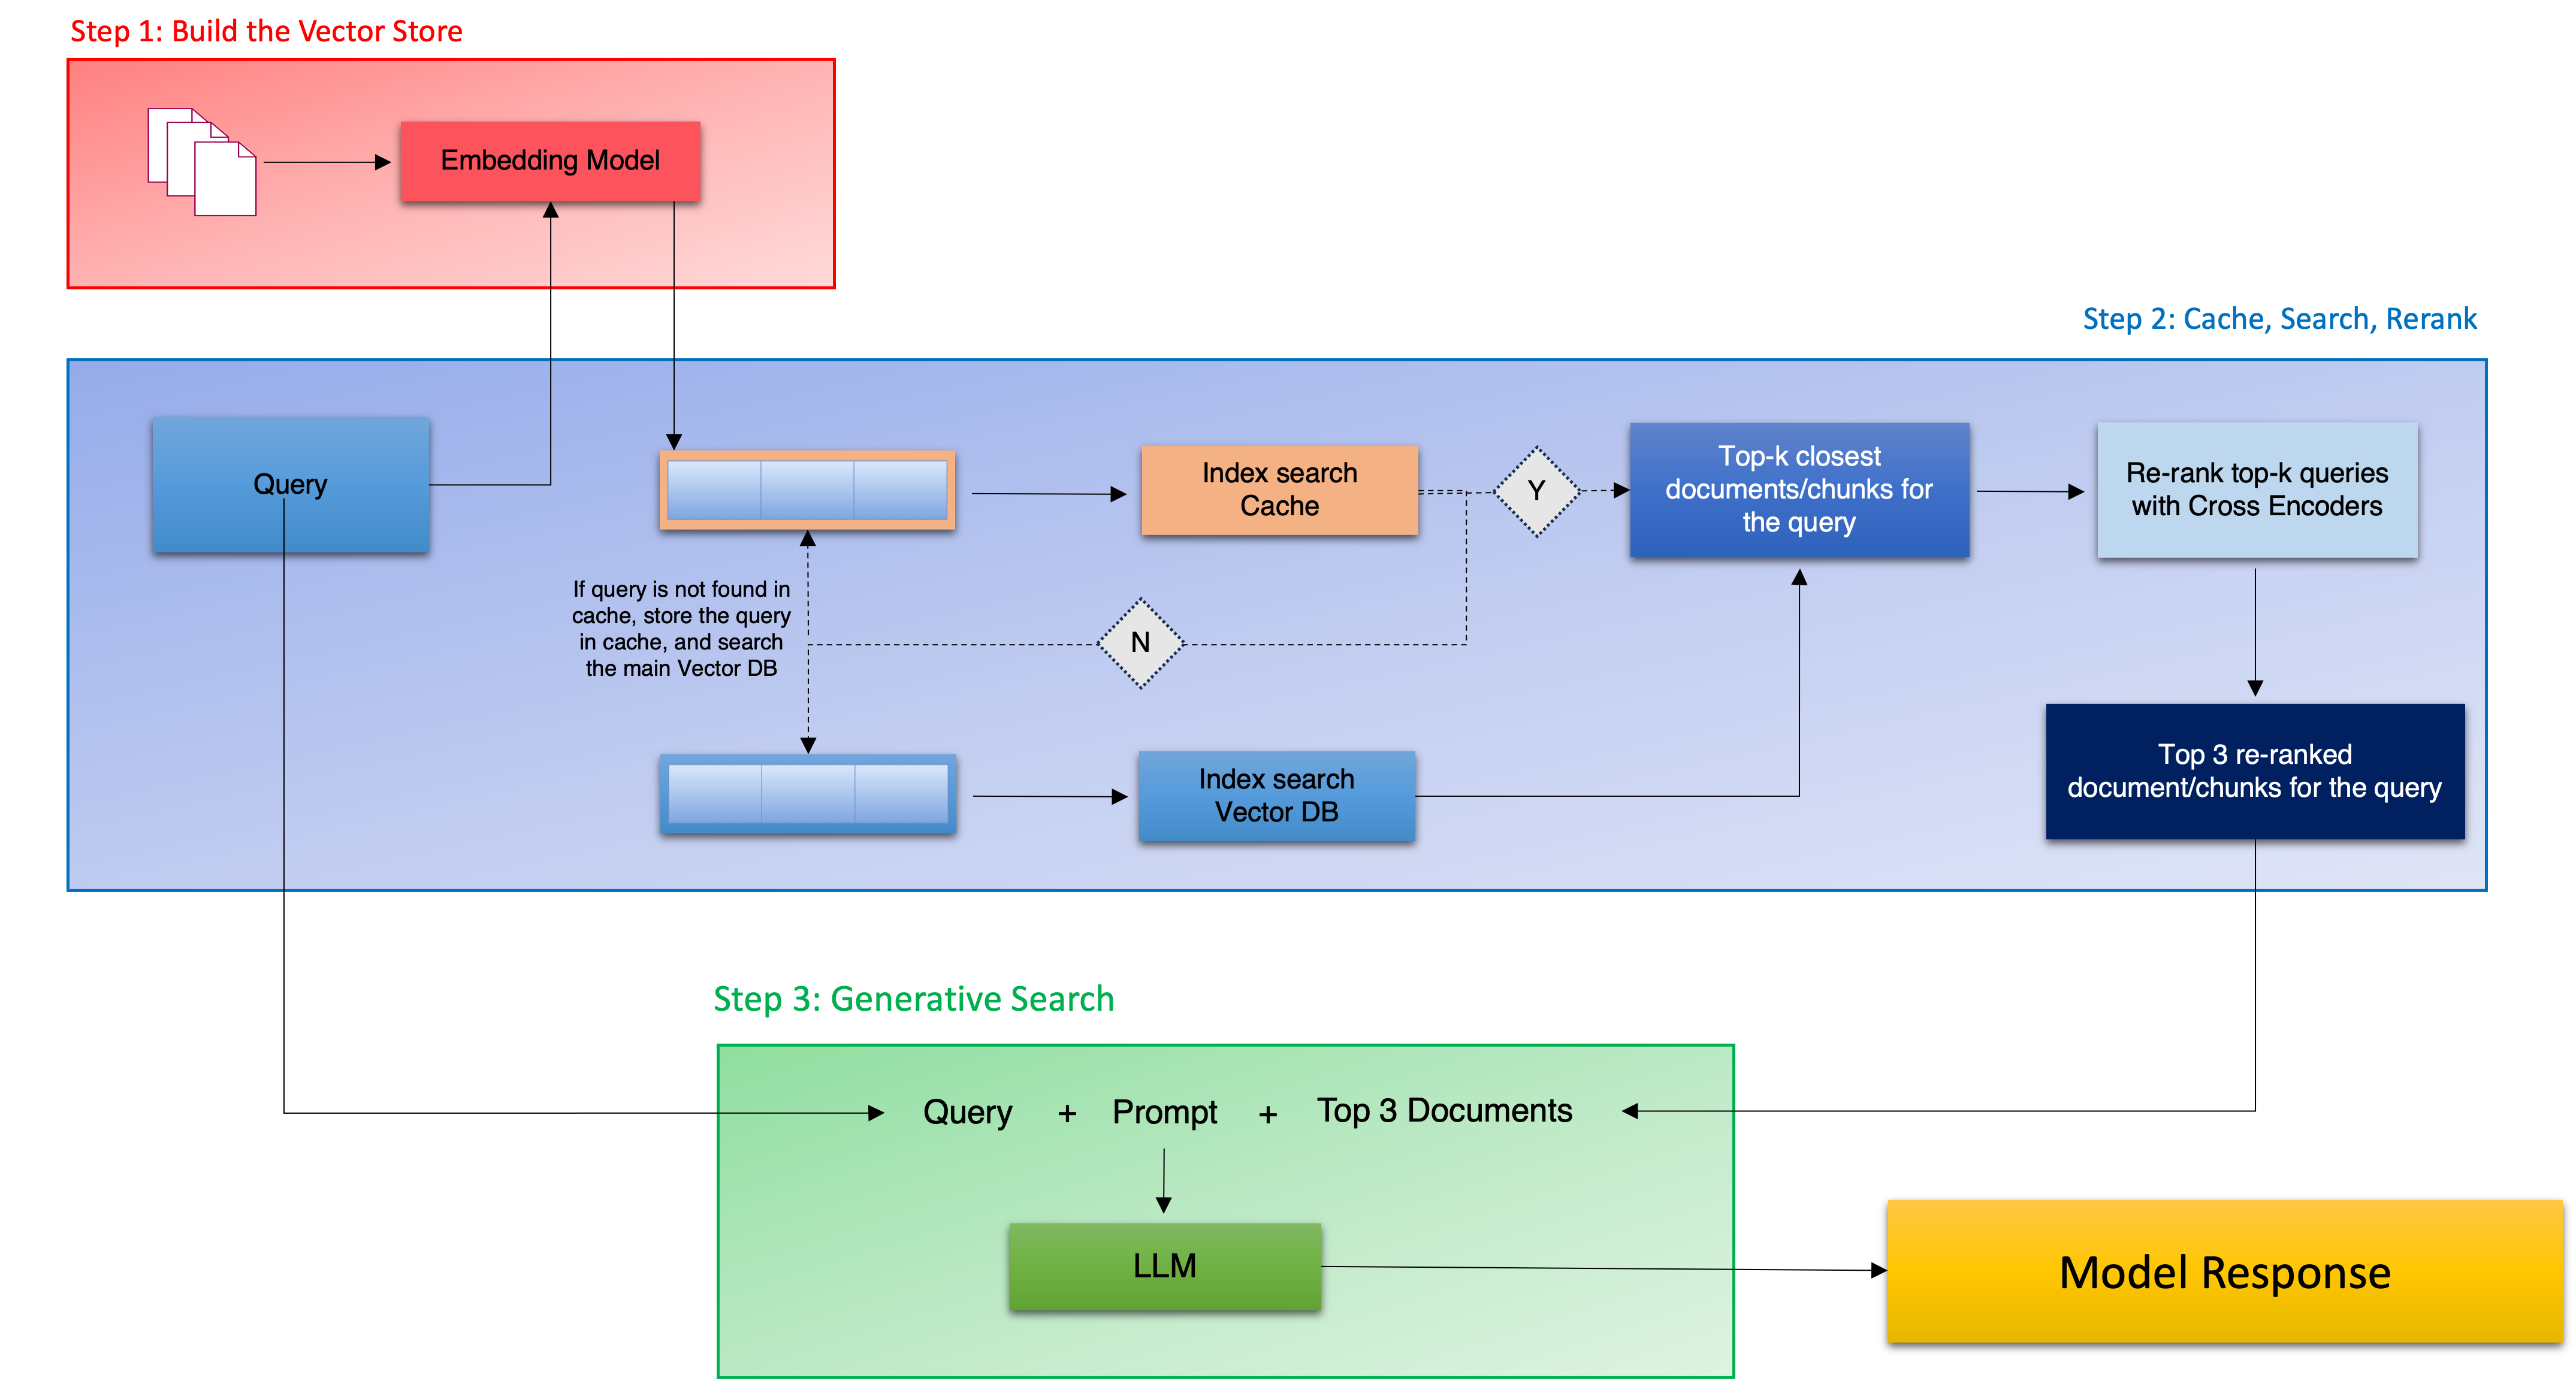

**Generation Layer**

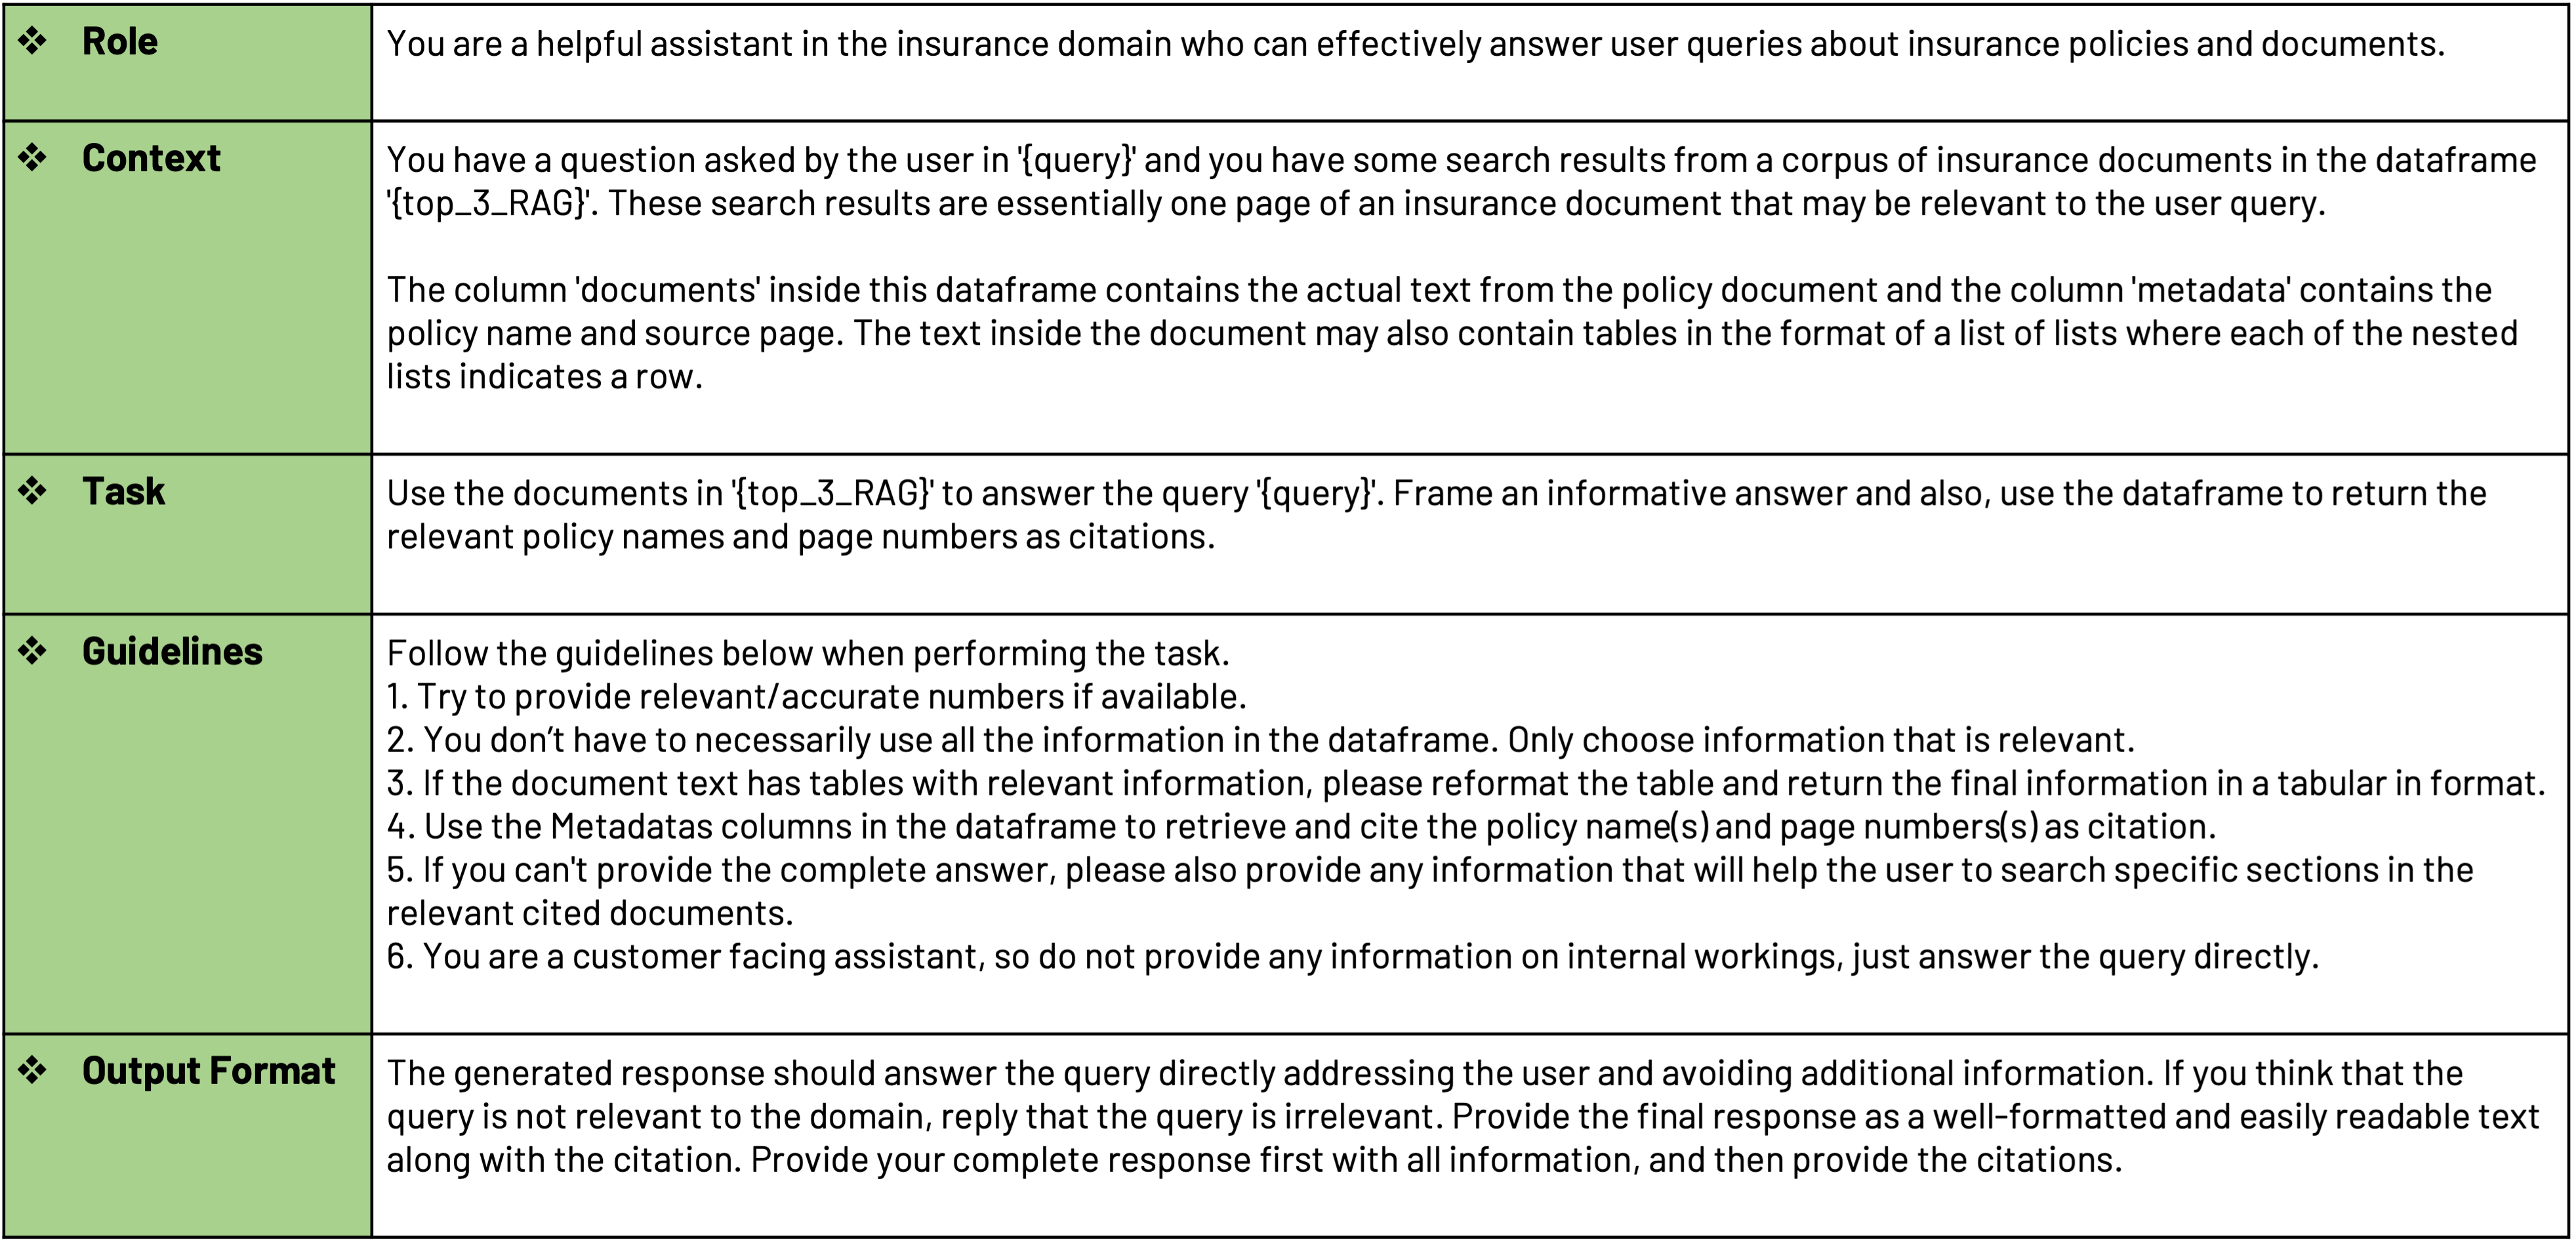

## 6. <font color = blue> Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [80]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [81]:
query

'Is this a good insurance plan?'

In [82]:
# Generate the response - For Query 1

response = generate_response(query, top_3_RAG_q1)
print("Query 1: ","\n",query,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")
# Print the response
print("\n".join(response))

Query 1:  
 Is this a good insurance plan? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Based on the information available in the documents, I can confirm that the insurance plan mentioned in the provided documents specifically details sections related to Individual Purchase Rights, Member Accidental Death and Dismemberment coverage, and eligibility criteria for Members. To assess whether this is a good insurance plan, I would need more specific details about your requirements and preferences.

If you are looking for information on these particular sections of the insurance plan mentioned in the documents, please refer to the following:

1. Section F - Individual Purchase Rights
2. Section B - Member Accidental Death and Dismemberment
3. Eligibility criteria for Members

To evaluate the overall quality a

In [83]:
query2

"What does it mean by 'the later of the Date of Issue'?"

In [84]:
# Generate the response - For Query 2

response2 = generate_response(query, top_3_RAG_q2)

print("Query 2: ","\n",query2,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")

# Print the response
print("\n".join(response2))

Query 2:  
 What does it mean by 'the later of the Date of Issue'? 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Based on the available documents, I don't have enough information to determine if the insurance plan is good or not. To make an accurate assessment, I would recommend reviewing the specific details and coverage provided in the policy documents such as the benefits, exclusions, limitations, and any additional terms and conditions.

**Citations:**
1. **Policy Name:** Principal Insurance Policy
   - **Page Number:** Page 29
2. **Policy Name:** Principal Insurance Policy
   - **Page Number:** Page 30
3. **Policy Name:** Principal Insurance Policy
   - **Page Number:** Page 31


In [85]:
query3

"What are the default benefits and provisions of the Group Policy?'"

In [86]:
# Generate the response - For Query 1

response3 = generate_response(query, top_3_RAG_q3)


print("Query 3: ","\n",query3,"\n_________________________________________________________________________________________________________________\n_________________________________________________________________________________________________________________\n")

# Print the response

print("\n".join(response3))

Query 3:  
 What are the default benefits and provisions of the Group Policy?' 
_________________________________________________________________________________________________________________
_________________________________________________________________________________________________________________

Based on the information available in the document, I can provide a detailed analysis to help you determine if this is a good insurance plan. However, please note that the specific details of the plan and its quality may vary, and it's recommended to carefully review the entire policy document for a comprehensive understanding.

Here is a breakdown of the provided insurance policy details that may influence whether it's a good plan:

1. The Principal has complete discretion: This clause suggests that the insurance provider has full authority and decision-making power over certain aspects of the policy, which could influence how claims and benefits are processed.

2. Policy Administr